# 7. Ensemble Learning and Random Forests-集合学习和随机森林


假设你向成千上万个随机人提出一个复杂的问题，然后汇总他们的答案。在许多情况下，你会发现这个汇总的答案比专家的答案更好。这被称为**人群的智慧**。同样，如果你汇总一组预测变量（例如分类器或回归量）的预测，你通常会获得比最佳个体预测变量更好的预测。一组预测因子称为**集合**;因此，这种技术称为**集合学习**，一个集合学习算法称为**集合方法**。

例如，您可以训练一组决策树分类器，每个都在训练集的不同随机子集上。要进行预测，您只需获得所有单个树的预测，然后预测获得最多选票的类别（参见第6章的最后一个练习）。**这样的决策树集合被称为随机森林**，尽管它很简单，但它是当今最强大的机器学习算法之一。

而且，正如我们在第2章中讨论的那样，一旦你已经构建了一些好的预测器，你就会**经常在项目结束时使用Ensemble方法**，将它们组合成一个更好的预测器。
事实上，机器学习竞赛中获胜的解决方案通常涉及多种Ensemble方法（最着名的是Netflix奖竞赛）。

在本章中，我们将讨论最流行的Ensemble方法，包括**bagging, boosting, stacking,** 和其他一些。我们还将探索**随机森林**。











1### Setup

In [1]:
#设置每行输出
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 
import numpy as np
def logprint(key,msg=None):
    type_key = type(key)
    if type_key ==str:
        shape = len(key)
    elif type_key ==np.ndarray:
        shape =key.shape
    else:
        shape =None
    if shape !=None:
        print(("logprint\tmsg:"+str(msg)+"\ttype:"+str(type(key))+"\tshape:"+str(shape)))
    else:
        print(("logprint\tmsg:"+str(msg)+"\ttype:"+str(type(key))))
    print(key)

In [2]:
# To support both python 2 and python 3
# 让这份笔记同步支持 python 2 和 python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
# 让笔记全程输入稳定
np.random.seed(42)

# To plot pretty figures
# 导入绘图工具
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
# 设定图片保存路径，这里写了一个函数，后面直接调用即可
PROJECT_ROOT_DIR = "F:\ML\Machine learning\Hands-on machine learning with scikit-learn and tensorflow"
PROJECT_ROOT_DIR =r"C:\Users\persp\workspace\GitHub\Hands-on-Machine-Learning"
CHAPTER_ID = "07_Ensemble Learning and Random Forests"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
# 忽略无用警告
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

### 7.1 Voting Classifiers

**投票分类器**

假设我们已经训练了一些分类器，每个分类器的准确率达到约80％。你可能有一个Logistic回归分类器，一个SVM分类器，一个随机森林分类器，K-Nearest Neighbors分类器，也许还有一些别的（见下图）

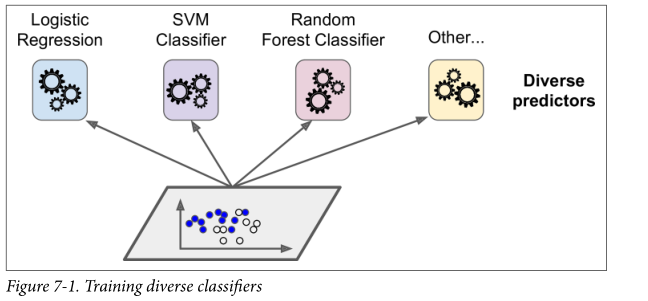



创建一个更好的分类器的一种非常简单的方法是**聚合每个分类器的预测并预测获得最多选票的类**。这种**多数表决分类器称为硬投票分类器**（见下图）。

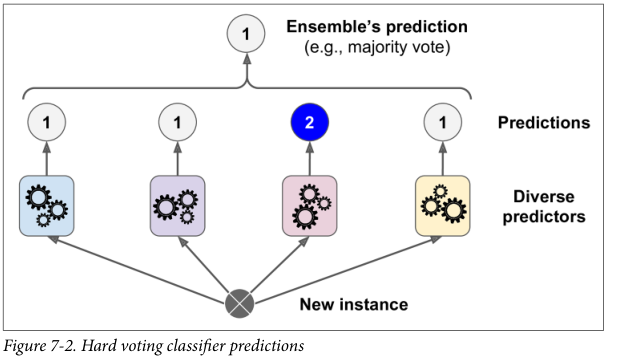

有些令人惊讶的是，这种**投票分类器通常比集合中的最佳分类器具有更高的准确度**。事实上，即使每个分类器都是弱学习者（意味着它只比随机猜测稍微好一些），整体仍然可以成为一个强大的学习者（达到高准确度），只要有足够数量的弱学习者并且他们足够多样化。

这怎么可能？ 以下类比可以帮助揭示这个谜团。假设你有一个稍微有偏见的硬币，有51％的机会出现**正面(头)** ， 并有49％的机会出现**反面(尾)** 。如果你扔1000次，你通常会得到或多或少510正和490反，因此大多数是正。 如果你做数学运算，你会发现在1000次投掷后获得大多数是正面的概率接近75％。
投掷硬币越多，概率就越高（例如，有10,000次投掷，概率攀升超过97％）。

这是由于**大数定律**：当你不停地掷硬币时，头部的比例越来越接近头部的概率（51％）。图7-3显示了10系列偏置硬币投掷。你可以看到，随着投掷次数的增加，正面的比例接近51％。 最终所有10个系列最终接近51％，并且一直高于50％。

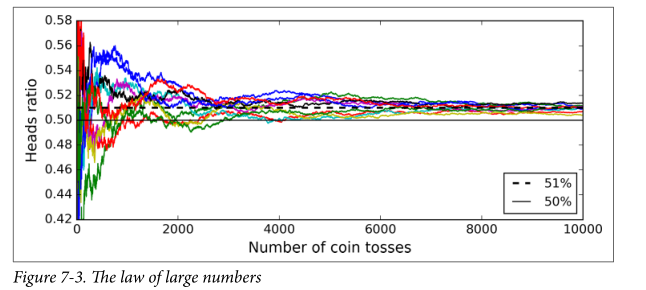

下面的代码用来产生图7-3

In [3]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

<Figure size 576x252 with 0 Axes>

Text(0.5,0,'Number of coin tosses')

Text(0,0.5,'Heads ratio')

[0, 10000, 0.42, 0.58]

Saving figure law_of_large_numbers_plot


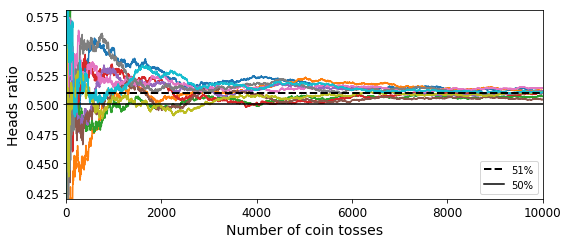

In [4]:
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
save_fig("law_of_large_numbers_plot")
plt.show()

同样，假设我们构建了一个包含1,000个分类器的集合只有51％的时间单独纠正（几乎比随机猜测更好）。如果你预测多数投票的类别，你可以希望高达75％的准确率！ 然而，**只有当所有分类器完全独立**时才会出现这种情况，从而产生不相关的错误，这显然不是这种情况，因为它们是在相同的数据上训练的。他们可能会犯同样类型的错误，因此错误的类会有很多多数选票，从而降低了整体的准确性。

**当预测变量尽可能彼此独立时，集合方法最有效**。 **获得不同分类器的一种方法是使用完全不同的算法训练它们**。 这增加了他们制造完全不同类型错误的机会，从而提高了整体的准确性。

以下代码在Scikit-Learn中**创建并训练投票分类器，包含三种不同的分类器**（训练集是moons dataset，在第5章介绍的）：

载入数据并划分训练集和测试集：

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X,y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

In [7]:
voting_clf.fit(X_train,y_train)

C:\Users\persp\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\persp\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\persp\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)), ('rf', RandomFore...rbf', max_iter=-1, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)

让我们看看每个分类器在测试集上的准确性：

In [8]:
from sklearn.metrics import accuracy_score

for clf in (log_clf,rnd_clf,svm_clf,voting_clf):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    
    print(clf.__class__.__name__,accuracy_score(y_test,y_pred))


C:\Users\persp\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

LogisticRegression 0.864


C:\Users\persp\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

RandomForestClassifier 0.872


C:\Users\persp\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=False)

SVC 0.888


C:\Users\persp\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\persp\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)), ('rf', RandomFore...rbf', max_iter=-1, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)

VotingClassifier 0.896


投票分类器略微优于所有单独的分类器。

如果所有分类器都能够估计类**概率**（即，他们有一个**predict_proba（）**方法），那么你可以告诉Scikit-Learn**预测具有最高等级概率的类**，对所有单个分类器进行平均。这称为**软投票**。 它通常比硬投票获得更高的性能，**因为它给予高度自信的投票更多的权重**。你需要做的就是**用voting =“soft”替换voting =“hard”**，并确保所有分类器都可以估计**类概率**。默认情况下，**SVC类不是估计概率**，因此需要**将其概率超参数设置为True**
（这将使SVC类使用**交叉验证**来估计类概率，减慢训练，并且它将添加predict_proba（）方法）。如果修改前面的代码以使用软投票，您会发现投票分类器的准确率达到91％以上！

In [9]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(probability=True,random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')

In [10]:
voting_clf.fit(X_train, y_train)

C:\Users\persp\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\persp\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\persp\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)), ('rf', RandomFore...'rbf', max_iter=-1, probability=True, random_state=42,
  shrinking=True, tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=None, voting='soft', weights=None)

In [11]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

C:\Users\persp\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

LogisticRegression 0.864


C:\Users\persp\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

RandomForestClassifier 0.872


C:\Users\persp\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=42,
  shrinking=True, tol=0.001, verbose=False)

SVC 0.888


C:\Users\persp\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\persp\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)), ('rf', RandomFore...'rbf', max_iter=-1, probability=True, random_state=42,
  shrinking=True, tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=None, voting='soft', weights=None)

VotingClassifier 0.912


### 7.2 Bagging and Pasting

**套袋和粘贴**

获得各种分类器的**一种方法是使用非常不同的训练算法**，就像刚刚讨论过的。 **另一种方法是对每个预测器使用相同的训练算法，但是在训练集的不同随机子集上训练它们**：

* When sampling is performed **with replacement**, this method is called **bagging** 
(short for bootstrap aggregating  ). 
* When sampling is performed **without replacement**, it is called **pasting**. 

换句话说，Bagging and Pasting都允许在多个**预测器**上对训练实例进行多次采样，但**只有bagging允许对同一预测变量对样本进行多次采样**。
该采样和训练过程如图7-4所示：

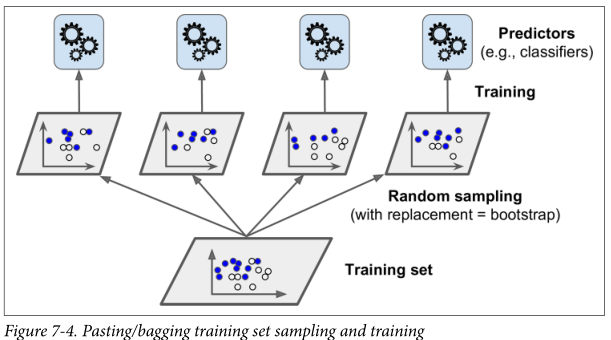

一旦训练了所有预测变量，集合就可以对新变量进行预测，例如，简单地汇总所有预测器的预测。聚合函数通常是分类的统计模式（即最常见的预测，就像硬投票分类器一样），或回归的平均值。 每个单独的预测器具有比在原始训练集上训练时更高的偏差，但是**聚合减少了偏差和方差**。 一般来说，最终结果是整体具有**相似的偏差**，但**方差低于在原始训练集上训练的单个预测器**。

如图7-4所示，预测器可以通过不同的CPU核心甚至不同的服务器进行并行训练。 同样，预测也可以并行进行。这是Bagging and Pasting如此受欢迎的原因之一：
**they scale very well**。

#### 7.2.1 Bagging and Pasting in Scikit-Learn

Scikit-Learn提供了一个简单的API使用**BaggingClassifier类**（或 **BaggingRegressor** 进行回归）进行**Bagging and Pasting**。以下代码训练500个决策树分类器的集合，each trained on 100 training instances randomly sampled from the training set with replacement（这是Bagging的一个例子，但是如果你想使用Pasting，只需设置bootstrap = False）。

**参数 n_jobs**告诉Scikit-Learn用于训练和预测的CPU核心数（ **-1** 告诉Scikit-Learn使用所有可用核心）：

In [12]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42),#  基类预测器
    n_estimators = 500,
    max_samples = 100, 
    bootstrap = True,
    n_jobs = -1,
    random_state=42
)

In [13]:
bag_clf.fit(X_train,y_train)
y_pred = bag_clf.predict(X_test)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=100, n_estimators=500, n_jobs=-1, oob_score=False,
         random_state=42, verbose=0, warm_start=False)

In [14]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [15]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

0.856


In [16]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

<Figure size 792x288 with 0 Axes>

Text(0.5,1,'Decision Tree')

Text(0.5,1,'Decision Trees with Bagging')

Saving figure decision_tree_without_and_with_bagging_plot


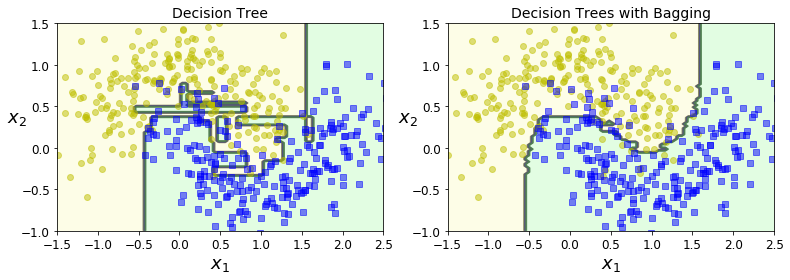

In [17]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

如果基类分类器可以**估计类概率**，则BaggingClassifier自动执行软投票而不是硬投票（即，如果它有predict_proba（）方法），决策树分类器(此时的基类是决策树)就是这种情况。

图7-5（即上图）比较单个决策树的决策边界与500棵树的Bagging集合（来自前面的代码）的决策边界，两者都在 moons 数据集上训练。正如你所看到的，**集合的预测可能会比单一决策树的预测更好地推广**：集合具有有竞争力的偏差，但方差较小（它使训练集上的错误数大致相同，但决策边界少一点不规则）。

Bootstrapping在每个预测器训练的子集中引入了更多的多样性，因此Bagging的最终会比Pasting的略高一些，但这也意味着预测器的相关性降低，因此整体的方差减小了。总的来说，Bagging通常会产生更好的模型，这就解释了为什么它通常是首选的。但是，如果您有空闲时间和CPU功率，则可以使用**交叉验证来评估Bagging和Pasting，并选择效果最佳的Bagging**。

#### 7.2.2 Out-of-Bag Evaluation

**对于任何给定的预测器，有些实例可能会被采样而其他实例可能根本没有被抽中**。默认情况下，BaggingClassifier会对 m 个训练实例进行替换(with replacement)（bootstrap = True），其中 m 是训练集的大小。这意味着每个预测器平均仅对约63％的训练实例进行采样。**剩余的37％未采样的训练实例称为out-of-bag (oob)实例**。请注意，对于所有预测器，它们不是相同的37％。

由于**预测器在训练期间从不会看到 oob 实例**，因此**可以在这些实例上进行评估，无需单独的验证集或交叉验证**。你可以通过平均每个预测器的  oob 评估来评估整体本身。

在Scikit-Learn中，你可以在创建BaggingClassifier时设置**oob_score = True**要求在训练后进行自动oob评估。
以下代码演示了这一点。最终的评估分数可通过**oob_score_变量**获得：

In [18]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42),#  基类预测器
    n_estimators=500,
    bootstrap = True,
    n_jobs = -1,
    oob_score=True,
    random_state=40
)

bag_clf.fit(X_train,y_train)
bag_clf.oob_score_
    

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=500, n_jobs=-1, oob_score=True,
         random_state=40, verbose=0, warm_start=False)

0.9013333333333333

根据这个oob评估，BaggingClassifier可能在测试集上达到约91.2％的准确度。 我们来验证一下：

In [19]:
from sklearn.metrics import accuracy_score

y_pred = bag_clf.predict(X_test)
accuracy_score(y_test,y_pred)

0.912

每个训练实例的oob决策特征也可以通过**oob_decision_function_变量**获得。在这种情况下（由于**基类估计器具有predict_proba（）**方法），决策函数返回每个训练实例的类概率。例如，oob评估估计第二个训练实例有65.89％属于positive class的概率（和属于negative class的34.11％）：

In [20]:

bag_clf.oob_decision_function_

array([[0.31746032, 0.68253968],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.08379888, 0.91620112],
       [0.31693989, 0.68306011],
       [0.02923977, 0.97076023],
       [0.97687861, 0.02312139],
       [0.97765363, 0.02234637],
       [0.74404762, 0.25595238],
       [0.        , 1.        ],
       [0.71195652, 0.28804348],
       [0.83957219, 0.16042781],
       [0.97777778, 0.02222222],
       [0.0625    , 0.9375    ],
       [0.        , 1.        ],
       [0.97297297, 0.02702703],
       [0.95238095, 0.04761905],
       [1.        , 0.        ],
       [0.01704545, 0.98295455],
       [0.38947368, 0.61052632],
       [0.88700565, 0.11299435],
       [1.        , 0.        ],
       [0.96685083, 0.03314917],
       [0.        , 1.        ],
       [0.99428571, 0.00571429],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.64804469, 0.35195531],
       [0.

### 7.3 Random Patches and Random Subspaces

BaggingClassifier类也支持对特征进行采样。这由两个超参数控制：

* max_features
* bootstrap_features。 

它们的工作方式与 **max_samples** 和 **bootstrap** 相同，但用于特征采样而不是实例采样。因此，将在输入特征的随机子集上训练每个预测器。

当你处理高维输入时，这尤其有用（如图像）。 对训练实例和特征进行采样称为**随机补丁方法**。保持所有训练实例（即，bootstrap = False和max_sam ples = 1.0）但是采样特征（即，bootstrap_features = True和/或max_fea小于1.0）被称为**随机子空间方法**。

采样特征导致预测器更多的多样性，为较低的方差交换更多的偏差。

### 7.4 Random Forests

正如我们所讨论的，随机森林是决策树的集合，通常通过Bagging方法（或有时Pasting）训练，通常**将max_samples设置为训练集的大小**。 您可以改为使用**RandomForestClassifier类**，而不是构建**BaggingClassifier**并将其传递给DecisionTreeClassifier，这样更方便并针对Decision Trees 进行了优化
（类似地，有一个**RandomForestRegressor类**用于回归任务）。以下代码使用所有可用的CPU核心训练具有500棵树（每个限制为最多16个节点）的随机森林分类器：

In [4]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier
rnd_clf.fit(X_train,y_train)

NameError: name 'X_train' is not defined

In [22]:
y_pred_rf = rnd_clf.predict(X_test)

In [23]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # almost identical predictions

0.944

除了少数例外，**RandomForestClassifier**包含**DecisionTreeClassifier**的所有超参数（用于控制树的生长方式），再加上**BaggingClassifier**的所有超参数来控制集合本身。

随机森林算法在种树时引入额外的随机性; 而不是在分割节点时搜索最佳功能（参见第6章），它在随机的特征子集中搜索最佳特征。这导致树木更大的多样性，其（再次）为较低的方差交换较高的偏差，通常产生整体更好的模型。 以下BaggingClassifier大致相当于之前的RandomForestClassifier

In [24]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, 
    max_samples=1.0, 
    bootstrap=True, 
    n_jobs=-1, 
    random_state=42
)

In [25]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=16,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='random'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=500, n_jobs=-1, oob_score=False,
         random_state=42, verbose=0, warm_start=False)

In [26]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

sepal length (cm) 0.11249225099876374
sepal width (cm) 0.023119288282510326
petal length (cm) 0.44103046436395765
petal width (cm) 0.4233579963547681


In [27]:
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

<Figure size 432x288 with 0 Axes>

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=16,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=16,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=43,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=16,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=44,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=16,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=45,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=16,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=46,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=16,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=47,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=16,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=48,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=16,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=49,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=16,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=50,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=16,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=51,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=16,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=52,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=16,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=53,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=16,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=54,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=16,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=55,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=16,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=56,
            splitter='best')

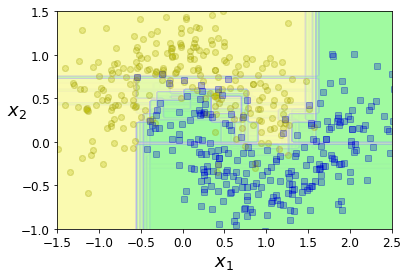

In [28]:
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X[indices_with_replacement], y[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.02, contour=False)

plt.show()

#### 7.4.1 Extra-Trees


当你在随机森林中种植树时，在每个节点处仅考虑特征的随机子集进行分割（如前所述）。通过**对每个特征使用随机阈值**而不是搜索最佳可能阈值（如常规决策树那样）时，可以**使树更加随机**。

这种极端随机的树木简称为**极端随机化树木集合(Extremely Randomized Trees ensemble)** （或简称Extra-Trees）。再一次，这为较低的方差换取了更多的偏差。它还**使Extra-Trees比常规随机森林更快地训练**，因为在每个节点找到每个特征的最佳阈值是种树时最耗时的任务之一。

你可以使用Scikit-Learn的ExtraTreesClassifier类创建Extra-Trees分类器。它的API与RandomForestClassifier类相同。同样，Extra TreesRegressor 类与RandomForestRegressor类具有相同的API。


事先很难判断RandomForestClassifier的性能是否比ExtraTreesClassifier更好或更差。通常，要知道的唯一方法是尝试两者并使用**交叉验证**（同时使用**网格搜索**调整超参数）来比较它们。

#### 7.4.2 Feature Importance

最后，如果你查看一个决策树可能会发现，**重要特征可能看起来更接近树的根，而不重要的特征通常会更接近叶子（或根本不显示）**。因此，可以通过计算特征在森林中所有树木中出现的**平均深度**来估计特征的重要性。Scikit-Learn会在训练后自动为每个特征计算。 你可以使用feature_importances_变量访问结果。

例如，以下代码训练鸢尾花数据集上的**RandomForestClassifier**（在第4章中介绍）并输出每个特征的重要性。似乎最重要的特征是**花瓣**长度（44％）和宽度（42％），而**萼片**的长度和宽度相比较不重要（分别为11％和2％）：

In [29]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500,n_jobs = -1)
rnd_clf.fit(iris["data"],iris["target"])
for name,score in zip(iris["feature_names"],rnd_clf.feature_importances_):
    print(name,score)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

sepal length (cm) 0.09628764623788374
sepal width (cm) 0.02346445420329403
petal length (cm) 0.41980536524343914
petal width (cm) 0.4604425343153836


同样，如果你在MNIST数据集上训练随机森林分类器（在第3章中介绍）并绘制每个像素的重要性，得到图7-6中所示的图像。

In [30]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

C:\Users\persp\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\persp\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


OSError: could not read bytes

In [ ]:
rnd_clf = RandomForestClassifier(random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

In [ ]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.hot,
               interpolation="nearest")
    plt.axis("off")

In [ ]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

save_fig("mnist_feature_importance_plot")
plt.show()

### 7.5 Boosting-提升

**提升**（**Boosting**，最初称为假设增强）指的是可以将几个弱学习者组合成强学习者的集成方法。对于大多数的提升方法的思想就是按顺序去训练分类器，每一个都要尝试修正前面的分类。现如今已经有很多的提升方法了，但最著名的就是 **Adaboost**（**适应性提升**，是 Adaptive Boosting 的简称） 和 **Gradient Boosting**（**梯度提升**）。让我们先从 Adaboost 说起。

#### 7.5.1 AdaBoost

新预测器纠正其前身的一种方法是更多地关注之前的预测器欠拟合的训练实例。 这导致新的预测器越来越关注比较难的实例。这是AdaBoost使用的技术。

举个例子，去构建一个 Adaboost 分类器，先训练第一个基类分类器（例如一个决策树），然后拿来在训练集上做预测，然后增加错误分类的训练实例的**相对权重**。 使用更新后的权重训练第二个分类器，并再次对训练集进行预测，更新权重，以此类推（详见图 7-7）
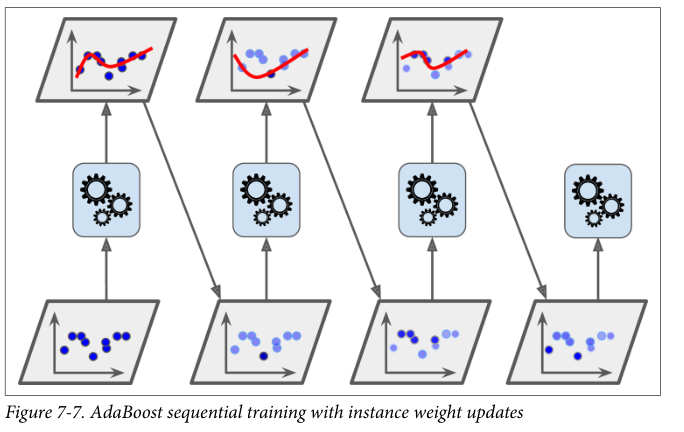

图7-8显示了 moons 数据集上五个连续预测器的决策边界（在此示例中，每个预测器是一个使用RBF内核的高度正则化的SVM分类器）。 第一个分类器导致许多实例错误，所以他们的权重得到提升。 因此，第二个分类器在这些实例上做得更好，等等。

右边的图表代表了相同的预测器序列，但学习率减半（即，错误分类的实例权重在每次迭代时增加一半）。正如你所看到的，这种顺序学习技术与Gradient Descent有一些相似之处，除了不是调整单个预测器的参数以最小化成本函数，AdaBoost为整体增加了预测器，逐渐使其变得更好
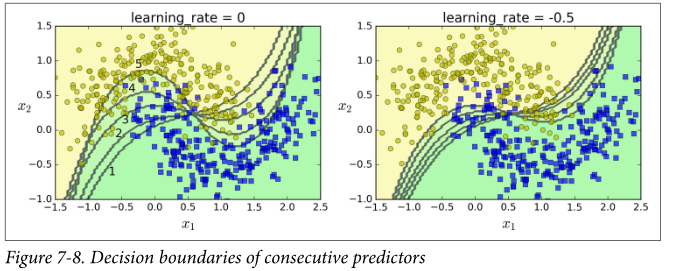

In [ ]:
##Adboost例子计算
##来自统计学习方法 P140
import math
def g(k,num):
    if num<k :
        return 1
    else :
        return -1
def sum_delta(k,x,y,D):
#   考虑基本分类器正反两级性
    sum =0
    for i in range(N):
        if y[i]==g(k,x[i]):
            delta_i =0
        else :
            delta_i =D[i]
#         print(delta_i)
        sum =sum + delta_i
    sum_1 =sum
    sum =0
    for i in range(N):
        if y[i]==-g(k,x[i]):
            delta_i =0
        else :
            delta_i =D[i]
#         print(delta_i)
        sum =sum + delta_i
    sum_2 =sum    
    sum =min(sum_1,sum_2)
    sum =float('%0.6f'%(sum))
    return sum 
def cal_margin():

    keylist =[]
    for i in range(10):
        keylist.append(i+0.5)
#     print(keylist)
    min_delta =sum_delta(keylist[0],x,y,D)
    min_index =keylist[0]
    for i in keylist:
        delta_k = sum_delta(i,x,y,D)
#         logprint(delta_k,"当前误差%s"%(str(i)))
        if delta_k<min_delta:
            min_delta= delta_k
            min_index =i
#     logprint(min_delta,"误差最小的值")
#     logprint(min_index,"误差最小的KEY")
    return min_index,min_delta
# D =[0.07143,0.07143,0.07143,0.07143,0.07143,0.07143,0.16667,0.16667,0.16667,0.07143]
D=[0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]

x =[0,1,2,3,4,5,6,7,8,9]
y=[1,1,1,-1,-1,-1,1,1,1,-1]
N=len(x)    
# cal_margin()

        
for m in range(1,5,1):
    min_index,min_error = cal_margin()

    alpha_m = 1/2 * math.log((1-min_error)/min_error)
    alpha_m = float('%0.4f'%(alpha_m))
    logprint(D,'%d轮:权重因子'%(m))
    logprint (min_index,'%d轮:阈值'%(m))
    logprint (min_error,'%d轮:最小误差率'%(m))
    logprint (alpha_m,'%d轮:权值系数'%(m))    
    print() 
    z_m =0
    for  i in range(N):
        z_m = z_m+D[i]*math.exp(-alpha_m*(y[i])*g(min_index,x[i]))
    for i in range(N):
        D[i]=float('%0.6f'%(D[i]/z_m*math.exp(-alpha_m*(y[i])*g(min_index,x[i]))))

In [ ]:
m = len(X_train)

plt.figure(figsize=(11, 4))
for subplot, learning_rate in ((121, 1), (122, 0.5)):
    sample_weights = np.ones(m)
    plt.subplot(subplot)
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.05, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 121:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)

save_fig("boosting_plot")
plt.show()

In [ ]:
list(m for m in dir(ada_clf) if not m.startswith("_") and m.endswith("_"))

一旦所有预测器都经过训练，集合使得预测非常类似于bagging or pasting，除了预测器具有不同的权重，这取决于它们在加权训练集上的总体准确性。

**这种顺序学习技术有一个重要的缺点**：它**不能被并行化**（或仅部分地），因为每个预测器只能在先前的预测器被训练和评估之后才能被训练。 因此，它不会像bagging or pasting那样可以扩展。

让我们仔细看看AdaBoost算法。 每个实例权重$ w^{(i)}$**最初**设置为$\frac{1}{m}$。 训练第一个预测器并在训练集上计算其加权误差率 $r_1$ ; 见公式7-1:
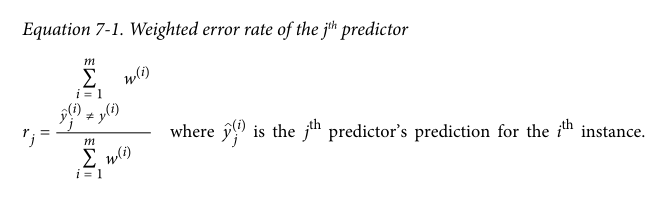

**然后**使用公式7-2计算**预测器的权重** $α_j$，其中 $η$是学习率超参数（默认为1）。预测器越精确，其权重就越高。

* 如果它只是随机猜测，那么它的权重将接近于零。 
* 如果它经常是错误的（即，比随机猜测更不准确），那么它的权重将是负的。
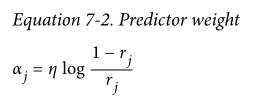

**接下来**，使用公式7-3更新实例权重：**错误分类的实例权重被提升**:
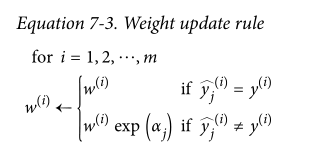

然后将所有实例**权重归一化**(即除以$Σ_{i=1}^mw^{(i)}$)

**最后**，使用更新后的权重训练新的预测器，并重复整个过程（计算新预测器的权重，更新实例权重，然后训练另一个预测器，等等）。当达到所需数量的预测器或找到完美预测器时，算法停止。 为了进行预测，AdaBoost只是计算所有预测器的预测值，并使用预测器权重 $α_j$对它们进行加权。
预测类是获得大多数加权投票的类（见公式7-4）。
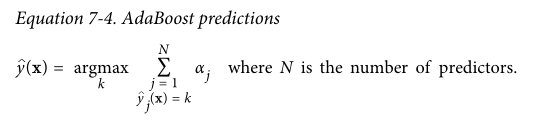

Scikit-Learn实际上使用了名为**SAMME**的多类AdaBoost（代表使用多类指数损失函数的Stagewise Additive Modeling）。**当只有两个类时，SAMME相当于AdaBoost**。此外，如果预测器可以估计类概率（即，如果他们有predict_proba（）方法），Scikit-Learn可以使用名为**SAMME.R的SAMME变体**（R代表“真实”），它依赖于类的概率而不是预测，并且通常表现更好。

以下代码使用Scikit-Learn的**AdaBoostClassifier类**训练基于200个决策树桩的**AdaBoost分类器**（正如你所料，还有一个**AdaBoostRegressor类**）。决策树桩是具有**max_depth = 1**的决策树 ——换句话说，是由单个决策节点加上两个叶节点组成的树。 这是AdaBoostClassifier类的默认基类估算器：

In [31]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), 
    n_estimators=200,
    algorithm="SAMME.R", 
    learning_rate=0.5, 
    random_state=42)

ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=200, random_state=42)

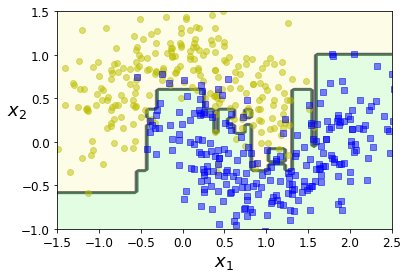

In [33]:
plot_decision_boundary(ada_clf, X, y)

**如果你的AdaBoost集合过拟合训练集，您可以尝试**减少估算器的数量**，或者强调**更正则化的基类估算器**。

#### 7.5.2 Gradient Boosting

另一个非常流行的Boosting算法是**Gradient Boosting**。就像AdaBoost一样，Gradient Boosting通过在一个集合中**依次添加预测器来进行工作，每一个都纠正它的前任**。 但是，这种方法不是像AdaBoost那样在每次迭代时调整实例权重，而是**尝试将新预测器拟合到先前预测器所产生的残差**。

让我们通过一个简单的回归示例，使用决策树作为基础预测器（当然，梯度提升也适用于回归任务）。 这称为**渐变树增强**（Gradient Tree Boosting）或**渐变增强回归树**（Gradient Boosted Regression Trees）（GBRT）。 首先，让DecisionTreeRegressor拟合训练集（例如，嘈杂的二次训练集）：

In [35]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [36]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth= 2)
tree_reg1.fit(X,y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

现在训练第二个DecisionTreeRegressor来解决第一个预测器遗留的残差：

In [37]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth = 2)
tree_reg2.fit(X,y2)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

然后我们训练第三个DecisionTreeRegressor来处理第二个预测器产生的残差：

In [38]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

现在我们有一个包含三棵树的集合。它可以简单地通过累加所有树的预测来对新实例进行预测：

In [39]:
X_new = np.array([[0.8]])

In [40]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [41]:
y_pred

array([0.75026781])

<Figure size 792x792 with 0 Axes>

Text(0,0.5,'$y$')

Text(0.5,1,'Residuals and tree predictions')

Text(0,0.5,'$y$')

Text(0.5,1,'Ensemble predictions')

Text(0,0.5,'$y - h_1(x_1)$')

Text(0,0.5,'$y$')

Text(0,0.5,'$y - h_1(x_1) - h_2(x_1)$')

Text(0.5,0,'$x_1$')

Text(0.5,0,'$x_1$')

Text(0,0.5,'$y$')

Saving figure gradient_boosting_plot


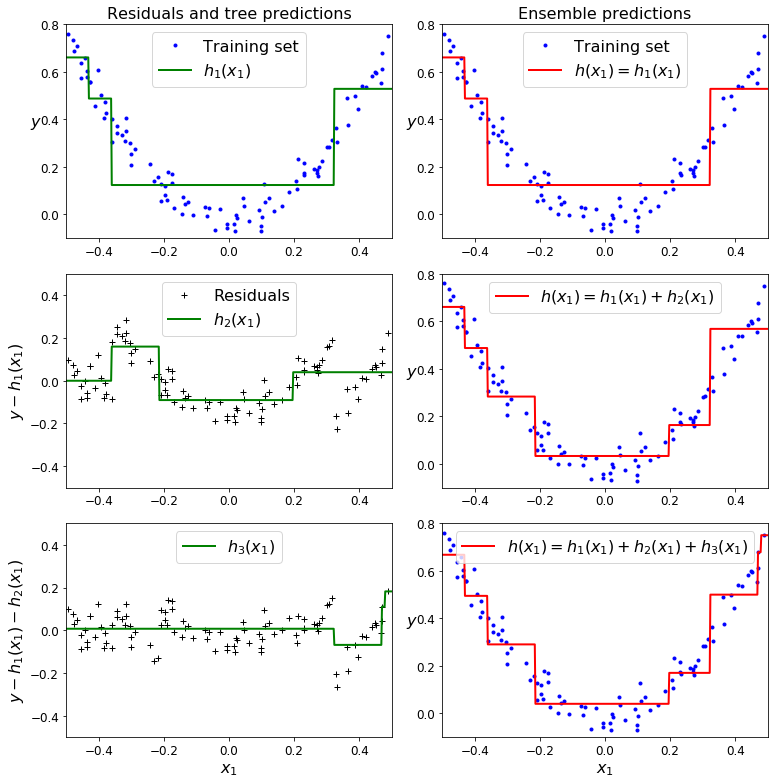

In [42]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

save_fig("gradient_boosting_plot")
plt.show()

图7-9（即上图）表示左列中这三棵树的预测，以及右栏中集合的预测。

* 在第一行中，集合只有一棵树，因此它的预测与第一棵树的预测完全相同。

* 在第二行中，对第一棵树的残差错误训练新树。在右侧，你可以看到**集合的预测等于前两棵树的预测总和**。

* 类似地，在第三行中，对第二树的残留错误训练另一棵树。你可以看到，随着树木被添加到整体中，集合的预测逐渐变得更好。


训练GBRT集合的一种更简单的方法是使用Scikit-Learn的**GradientBoostingRegressor类**。与**RandomForestRegressor类**非常相似，它具有：

* 控制决策树增长的超参数（例如，max_depth，min_samples_leaf等），

* 控制集合训练的超参数，例如树的数量（n_estimators）。以下代码创建与前一个相同的集合：

In [43]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(
    max_depth=2, 
    n_estimators=3, 
    learning_rate=1.0, 
    random_state=42
)

gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=1.0, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=3, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

**learning_rate超参数**缩放每棵树的贡献。**如果将其设置为较低的值，例如0.1，你需要更多的树木才能适应训练集，但预测通常会更好地概括**。 这是一种称为**shrinkage**的正则化技术。



In [44]:
gbrt_slow_1 = GradientBoostingRegressor(
    max_depth=2, 
    n_estimators=3, 
    learning_rate=0.1, 
    random_state=42
)

gbrt_slow_1.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=3, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [45]:
gbrt_slow_2 = GradientBoostingRegressor(
    max_depth=2, 
    n_estimators=200, 
    learning_rate=0.1, 
    random_state=42
)

gbrt_slow_2.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

<Figure size 792x288 with 0 Axes>

Text(0.5,1,'learning_rate=1.0, n_estimators=3')

NameError: name 'gbrt_slow' is not defined

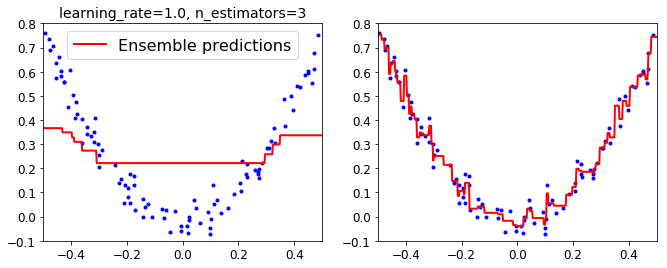

In [46]:
plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions([gbrt_slow_1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_slow_2], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)

save_fig("gbrt_learning_rate_plot")
plt.show()

图7-10（即上图）显示了以低学习率训练的两个GBRT集合：左边的那个没有足够的树来拟合训练集，而右边的那个有太多的树并且过拟合训练集。

**7.5.2.1 Gradient Boosting with Early stopping**

为了找到最佳树木数量，您可以使用**提前停止-Early stopping**（见第4章）。 实现这一点的**一种简单方法**是使用**staged_predict（）**方法：它返回一个迭代器，该迭代器覆盖整个训练阶段的集合所做的预测（有一棵树，两棵树等）。 

以下代码训练带有120棵树的GBRT集合，然后测量每个训练阶段的**验证误差**以找到最佳树木数量，最后使用最佳树木数量训练另一个GBRT集合：

In [47]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]

bst_n_estimators = np.argmin(errors)

gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=120, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=55, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [48]:
min_error = np.min(errors)
print(min_error)

0.002712853325235463


<Figure size 792x288 with 0 Axes>

Text(55,0.00325542,'Minimum')

[0, 120, 0, 0.01]

Text(0.5,0,'Number of trees')

Text(0.5,1,'Validation error')

Text(0.5,1,'Best model (55 trees)')

Saving figure early_stopping_gbrt_plot


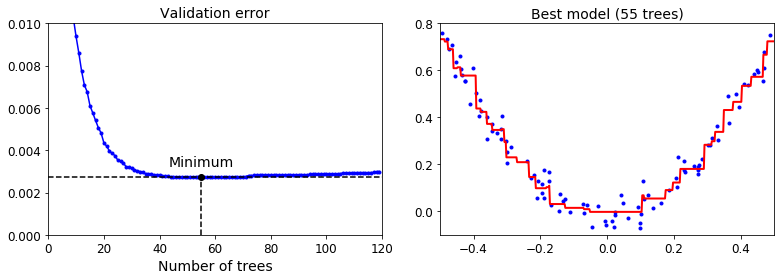

In [49]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)

save_fig("early_stopping_gbrt_plot")
plt.show()

验证错误显示在图7-11的左侧，最佳模型的预测显示在右侧。


实际中**也可以通过早期停止训练来实现早期停止**（而不是先培养大量树木，然后回头寻找最佳数量）。你可以通过设置**warm_start = True**来实现，这使得Scikit-Learn在调用fit（）方法时保留现有树，从而允许增量训练。 当**验证错误连续五次迭代没有改进时**，以下代码停止训练：

In [50]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=1, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=2, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=3, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=4, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=5, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=6, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=7, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=8, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=9, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=10, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=11, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=12, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=13, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=14, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=15, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=16, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=17, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=18, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=19, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=20, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=21, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=22, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=23, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=24, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=25, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=26, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=27, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=28, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=29, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=30, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=31, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=32, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=33, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=34, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=35, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=36, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=37, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=38, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=39, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=40, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=41, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=42, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=43, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=44, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=45, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=46, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=47, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=48, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=49, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=50, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=51, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=52, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=53, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=54, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=55, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=56, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=57, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=58, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=59, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=60, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=61, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

In [51]:
print(gbrt.n_estimators)

61


In [52]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.002712853325235463


**GradientBoostingRegressor类**还支持子样本超参数，它指定用于训练每棵树的**训练实例的百分数**。例如，如果subsample = 0.25，则每个树在25％的训练实例上进行训练，随机选择。 正如你现在可能猜到的那样，**对于较低的方差，这会产生较高的偏差**。 它还大大加快了训练速度。 这种技术称为**随机梯度增强（Stochastic Gradient Boosting）**。

可以使用Gradient Boosting和其他成本函数。这由损失超参数控制（有关详细信息，请参阅Scikit-Learn的文档）。

### 7.6 Stacking

我们在本章讨论的最后一个Ensemble方法称为**堆叠**（叠加泛化的简称）。它基于一个简单的想法：为什么我们不**训练模型来执行这种聚合**？而不是使用简单的函数（如硬投票）来聚合集合中所有预测器的预测， 图7-12显示了这样一个集合在新实例上执行回归任务。

* 底部三个预测变量中的每一个预测不同的值（3.1,2.7和2.9），

* 然后最终预测器（**称为混合器或元学习器--blender, or a meta learner**）将这些预测**作为输入**并进行最终预测（3.0）。
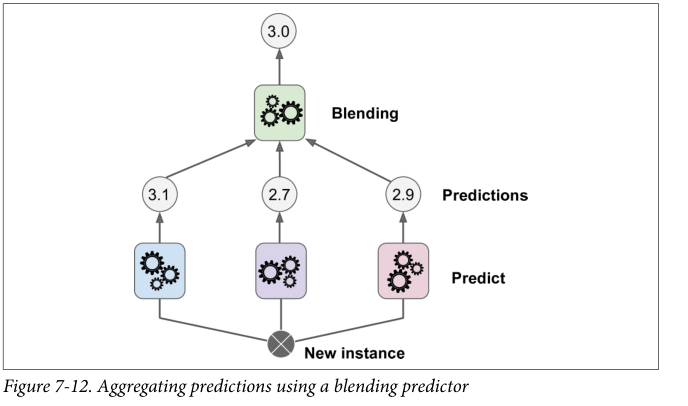

为了训练混合器或元学习器，一种常见的方法是使用**hold-out set**。让我们看看它是如何工作的。 

**首先**，训练集分为两个子集。 第一个子集用于训练第一层中的预测器（有三个）（见图7-13）。
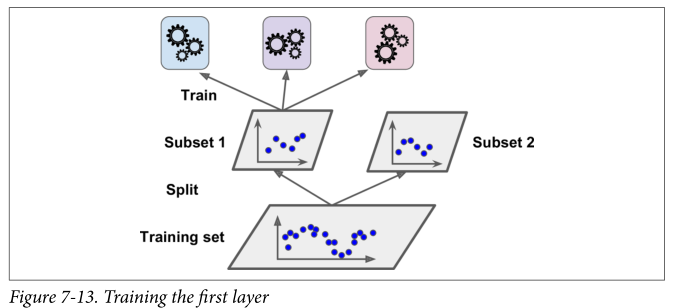


**接下来**，第一层预测器被用于在第二个子集进行预测（hold-out）（见图7-14）。 这可以确保预测“干净”，因为预测器在训练期间从未见过这些实例。 

**现在**，对于 hold-out 集中的每个实例，有三个预测值。 我们可以使用这些预测值作为**输入特征**（这使得这个新的训练集为三维）创建一个**新的训练集**，并保持目标值。 混合器或元学习器在这个新的训练集上训练，因此它基于第一层的预测结果，学习预测目标值。

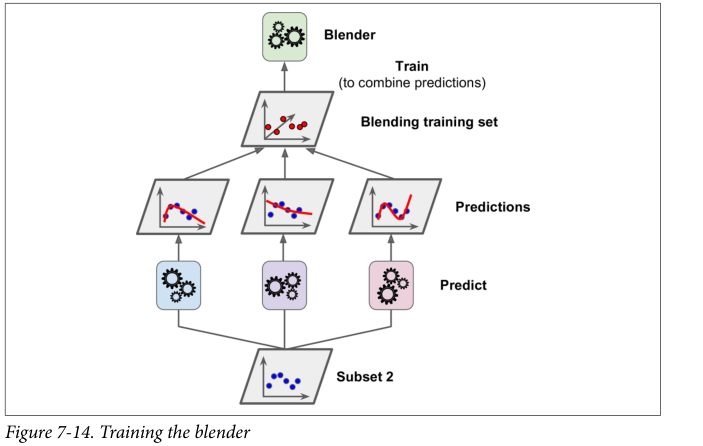

实际上可以用这种方式训练几种不同的搅拌器（例如，一个使用线性回归，另一个使用随机森林回归，等等）：我们得到一整层搅拌器。 诀窍是将训练集分成三个子集：

* 第一个用于训练第一层，
* 第二个用于创建用于训练第二层的训练集（使用由第一层的预测器做出的预测）
* 第三个用于创建训练集以训练第三层（使用第二层预测器的预测）。

完成此操作后，我们可以按顺序遍历每个层来预测新实例，如图7-15所示。

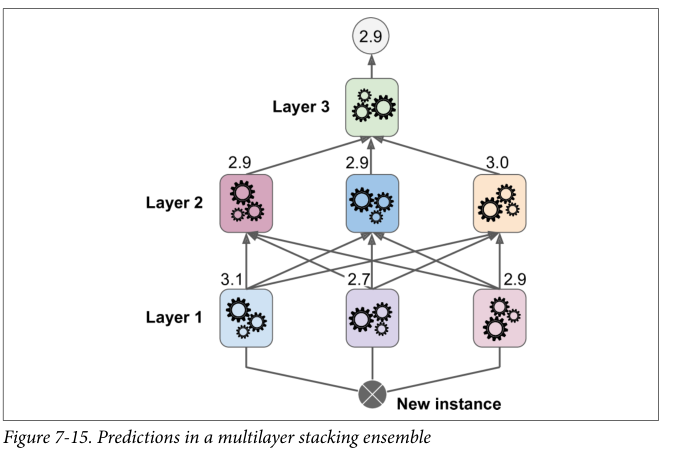

不幸的是，Scikit-Learn不支持**直接堆叠**，但是推出自己的实现并不太难（参见以下练习）。 或者，你可以使用Brew等开源实现
（可在[https://github.com/viisar/brew] 获得）。

### Using XGBoost

In [57]:
# http://localhost:8888/notebooks/workspace/GitHub/Hands-on-Machine-Learning/07_Ensemble%20Learning%20and%20Random%20Forests.ipynb#Using-XGBoosttry:
import xgboost
# except ImportError as ex:
#     print("Error: the xgboost library is not installed.")
#     xgboost = None

In [58]:
if xgboost is not None:  # not shown in the book
    xgb_reg = xgboost.XGBRegressor(random_state=42)
    xgb_reg.fit(X_train, y_train)
    
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    print("Validation MSE:", val_error)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

Validation MSE: 0.0028512559726563943


In [59]:
if xgboost is not None:  # not shown in the book
    xgb_reg.fit(X_train, y_train,
                eval_set=[(X_val, y_val)], 
                early_stopping_rounds=2
               )
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    print("Validation MSE:", val_error)

[0]	validation_0-rmse:0.286719
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:0.258221
[2]	validation_0-rmse:0.232634
[3]	validation_0-rmse:0.210526
[4]	validation_0-rmse:0.190232
[5]	validation_0-rmse:0.172196
[6]	validation_0-rmse:0.156394
[7]	validation_0-rmse:0.142241
[8]	validation_0-rmse:0.129789
[9]	validation_0-rmse:0.118752
[10]	validation_0-rmse:0.108388
[11]	validation_0-rmse:0.100155
[12]	validation_0-rmse:0.09208
[13]	validation_0-rmse:0.084791
[14]	validation_0-rmse:0.078699
[15]	validation_0-rmse:0.073248
[16]	validation_0-rmse:0.069391
[17]	validation_0-rmse:0.066277
[18]	validation_0-rmse:0.063458
[19]	validation_0-rmse:0.060326
[20]	validation_0-rmse:0.0578
[21]	validation_0-rmse:0.055643
[22]	validation_0-rmse:0.053943
[23]	validation_0-rmse:0.053138
[24]	validation_0-rmse:0.052415
[25]	validation_0-rmse:0.051821
[26]	validation_0-rmse:0.051226
[27]	validation_0-rmse:0.051135
[28]	validation_0-rmse:0.05091
[29]	validation_0-rmse

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

Validation MSE: 0.002528626115371327


In [60]:
%timeit xgboost.XGBRegressor().fit(X_train, y_train) if xgboost is not None else None

6.36 ms ± 370 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [61]:
%timeit GradientBoostingRegressor().fit(X_train, y_train)

19.4 ms ± 1.53 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Exercises

**1. to 7.**
See [Chapter - 7 Exercise(1-7)](https://www.jianshu.com/p/37e086c76708)

### 8. Voting Classifier

练习：加载MNIST数据并将其拆分为训练集，验证集和测试集（例如，使用50,000个实例进行训练，10,000个用于验证，10,000个用于测试）。

In [62]:
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split

mnist = fetch_mldata('MNIST original')

X_train_val, X_test, y_train_val, y_test = train_test_split(
    mnist.data, mnist.target, test_size=10000, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=10000, random_state=42)

C:\Users\persp\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\persp\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


OSError: could not read bytes

练习：然后训练各种分类器，例如随机森林分类器，Extra-Trees分类器和SVM。

In [ ]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

random_forest_clf = RandomForestClassifier(random_state=42)
extra_trees_clf = ExtraTreesClassifier(random_state=42)
svm_clf = LinearSVC(random_state=42)
mlp_clf = MLPClassifier(random_state=42)

estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf]
for estimator in estimators:
    print("Training the", estimator)
    estimator.fit(X_train, y_train)

In [ ]:
[estimator.score(X_val, y_val) for estimator in estimators]

**线性SVM**远远优于其他分类器。 但是，让我们暂时保留它，因为它可以改善投票分类器的性能。

练习：接下来，尝试使用**软或硬投票分类器将它们组合成一个在验证集上优于所有分类器的集合**。

In [ ]:
from sklearn.ensemble import VotingClassifier

named_estimators = [
    ("random_forest_clf", random_forest_clf),
    ("extra_trees_clf", extra_trees_clf),
    ("svm_clf", svm_clf),
    ("mlp_clf", mlp_clf),
]

voting_clf = VotingClassifier(named_estimators)
voting_clf.fit(X_train, y_train)

In [ ]:
voting_clf.score(X_val, y_val)

In [ ]:
[estimator.score(X_val, y_val) for estimator in voting_clf.estimators_]

让我们删除SVM以查看性能是否有所改善。 可以通过使用**set_params（）**将其设置为**None**来删除估计器，如下所示：

In [ ]:
voting_clf.set_params(svm_clf=None)

这更新了估计器列表：

In [ ]:
voting_clf.estimators

但是，它没有更新已经训练过的估计器列表(it did not update the list of trained estimators:)：

In [ ]:
voting_clf.estimators_

所以我们可以再次拟合VotingClassifier，或者只是从经过训练的估计器列表中删除SVM：

In [ ]:
del voting_clf.estimators_[2]

现在让我们再次评估**VotingClassifier**：

In [ ]:
voting_clf.score(X_val, y_val)

好多了！ SVM损害了性能。 现在让我们尝试使用软投票分类器。 我们实际上不需要重新训练分类器，我们可以将投票设置为“soft”：

In [ ]:
voting_clf.voting = "soft"
voting_clf.score(X_val, y_val)

这是一项重大改进，并且比每个单独的分类器都要好得多。

一旦你找到一个集合后，在测试集上试一试。 与单个分类器相比，它的表现有多好？

In [ ]:
voting_clf.score(X_test, y_test)

In [ ]:
[estimator.score(X_test, y_test) for estimator in voting_clf.estimators_]

投票分类器将错误率从我们最佳模型（MLPClassifier）的约4.9％降低到仅3.5％。 这大约减少28％的错误，不错！

### 9. Stacking Ensemble

练习：
运行上一练习中的**各个分类器以对验证集**进行预测，并**使用预测结果创建新的训练集**：每个训练实例是一个向量，包含来自图像的所有分类器的预测集，目标是 图像的类。 在这个新训练集上训练分类器。

In [ ]:
X_val_predictions = np.empty((len(X_val), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_val)
    
X_val_predictions

In [ ]:
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)
rnd_forest_blender.fit(X_val_predictions, y_val)

In [ ]:
rnd_forest_blender.oob_score_

你可以微调这个搅拌机或尝试其他类型的搅拌机（例如，MLPClassifier），然后一如既往地使用**交叉验证**选择最佳的一个。

练习：恭喜你，你刚刚训练了一个搅拌器，并与分类器一起组成了一个堆叠集合！现在让我们在测试集上评估这个集合。 
- 对于测试集中的每个图像，使用所有分类器进行预测，
- 然后将预测提供给搅拌器以获得集合的预测。 

它与你之前训练过的投票分类器相比如何？

In [ ]:
from sklearn.metrics import accuracy_score

X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)
    
y_pred = rnd_forest_blender.predict(X_test_predictions)

accuracy_score(y_test, y_pred)

这种堆叠集合的表现不如我们之前训练过的软投票分类器，但它仍然胜过所有单独的分类器。